# Baseline Model

## Introducción
En esta notebook se implementa un modelo base de forecasting que servirá como referencia para evaluar futuras mejoras. El modelo base nos permitirá establecer un punto de partida y medir la efectividad de técnicas más avanzadas.


## 1. Importación de Librerías

In [2]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind

## 2. Configuración del Entorno

In [3]:
# Configuración de opciones de pandas
pd.set_option('display.max_columns', None)


# Configuración para reproducibilidad
np.random.seed(42)

data_dir = '../data/'
models_dir = '../models/'

## 3. Carga de Datos

In [129]:
df_train=pd.read_parquet(f'{data_dir}df_train_att.parquet')
df_test=pd.read_parquet(f'{data_dir}df_test_att.parquet')
df_dev=pd.read_parquet(f'{data_dir}df_dev_att.parquet')
df_vo=pd.read_parquet(f'{data_dir}df_vo_att.parquet')

df_train.shape,df_test.shape,df_dev.shape,df_vo.shape

((103214, 24), (25668, 24), (32405, 24), (14223, 24))

## 4. Preparación de los Datos para el Modelo Base

In [188]:
var_modelo=['paymentDays_cap',
  'amountFinanced_log_abs_cap',
 # 'prbm_paymentDays',
  'prbm_sector',
  #'amountFinanced_sqrt_modified', # esta variable no ingresa 
  'payerSalesSegment',
  'expirationDays_log_abs_cap']

In [141]:
X_train=df_train[df_train["vd"].isin([0,1])][var_modelo]
y_train=df_train[df_train["vd"].isin([0,1])]['vd']

In [186]:
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.Logit(endog=y_train, exog=X_train,)
modelo = modelo.fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.062226
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                     vd   No. Observations:               102108
Model:                          Logit   Df Residuals:                   102102
Method:                           MLE   Df Model:                            5
Date:                Sat, 07 Dec 2024   Pseudo R-squ.:                  0.4688
Time:                        20:59:25   Log-Likelihood:                -6353.7
converged:                       True   LL-Null:                       -11960.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -10.0784      0.305    -32.992      0.000     

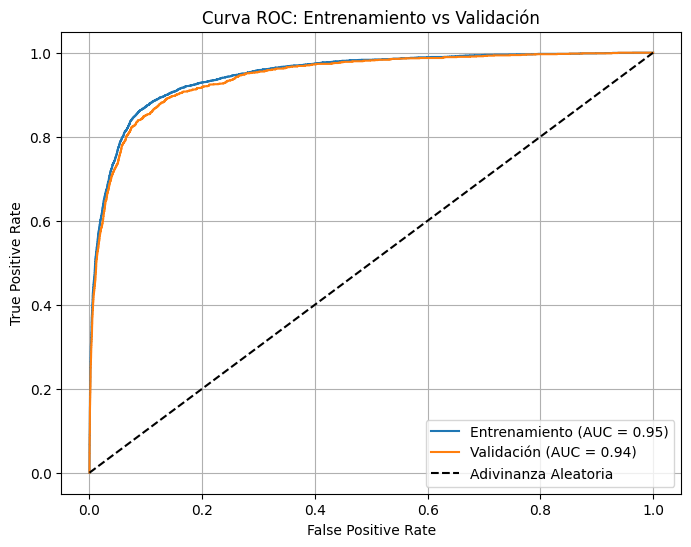

In [189]:
## se observa un modelo estable 
curva_roc(df_train,pd.concat([df_test,df_dev]),modelo,variables=var_modelo,vd="vd")

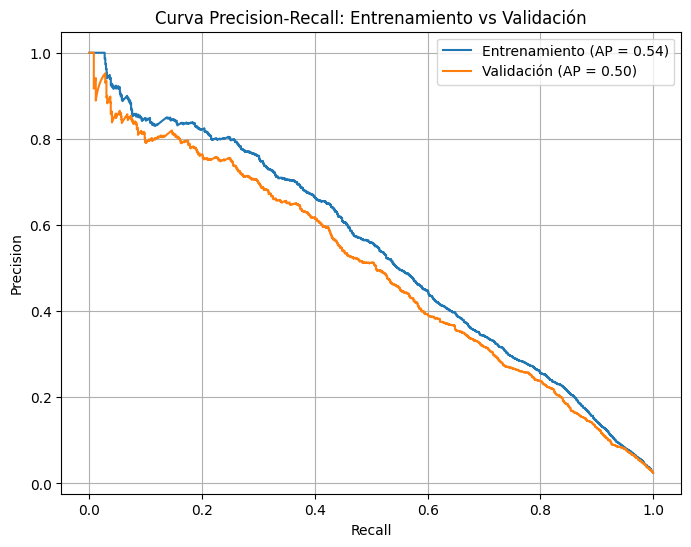

In [144]:
## si bien es un modelo establa tiene muy baja performance

curva_precision_recall(df_train,pd.concat([df_test,df_dev]),modelo,variables=var_modelo,vd="vd")

## 5. Pipeline 

In [150]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class CustomNumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforma los datos aplicando la lógica personalizada.
        """

        X['date']=pd.to_datetime(X['date'])
        X['paymentDate']=pd.to_datetime(X['paymentDate'])
        X['fecha_observacion']=pd.to_datetime(X['fecha_observacion'])
        X['expirationDate']=pd.to_datetime(X['expirationDate'])
        X['paymentDays'] = np.where(X['paymentDate'].isnull(),(X['fecha_observacion'] - X['expirationDate']).dt.days, # fecha de corte "foto"
                                    (X['paymentDate'] - X['expirationDate']).dt.days)
        
        X["paymentDays_cap"]=X["paymentDays"].clip(lower=-178, upper=203)

        X['amountFinanced']=np.where(X['amountFinanced'].isnull(),713881,X['amountFinanced'])
        X["amountFinanced_log_abs"]= np.sign(X['amountFinanced']) * np.log(np.abs(X['amountFinanced']) + 1)
        X["amountFinanced_log_abs_cap"]=X["amountFinanced_log_abs"].clip(lower=0, upper=22)

        X['expirationDays'] = (X['expirationDate'] - X['date']).dt.days
        X["expirationDays_log_abs"]= np.sign(X['expirationDays']) * np.log(np.abs(X['expirationDays']) + 1)
        X["expirationDays_log_abs_cap"]=X["expirationDays_log_abs"].clip(lower=1.79, upper=5.257495)

        return X[['paymentDays_cap',
                'amountFinanced_log_abs_cap',
                'payerSalesSegment',
                'expirationDays_log_abs_cap']]
    
class CustomCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass


    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """
        Transforma los datos aplicando la lógica personalizada.
        """
        sector_1=['Laboratorios y Fabricación Productos Farmacéuticos', 'Aerolíneas',
       'Suministro de Agua', 'Combustibles y Gas', 'Servicios de Salud',
       'Seguros e Isapres', 'Medios de Comunicación', 'Quimicos y Maderas']
        sector_2=['Retail', 'Ganadería', 'Acuicultura y Pesca', 'Minería y Metales']
        sector_3=['Construcción Ingeniería e Infraestructura']
        sector_4=['Hoteles, Restaurantes y Ocio', 'Agricultura y Relacionados',
            'Telecomunicaciones', 'Mercados de Capitales', 'Transporte',
            'Envíos y Almacenamiento', 'Energía', 'Relacionados a Construccion']
        sector_5=['Comercio', 'Consumo Basico', 'Servicios',
            'Tecnología de la Información', 'Gobierno y Actividades Sociales',
            'Maquinaria y Equipo','Industria Automotriz']
        sector_6=['Educación', 'Construcción de Viviendas', 'Tabaco']

        X["prbm_sector"]=np.where(X["sector"].isin(sector_1),0.000409,
        np.where(X["sector"].isin(sector_2),0.002683,
        np.where(X["sector"].isin(sector_3),0.005458,
        np.where(X["sector"].isin(sector_4),0.023589,
        np.where(X["sector"].isin(sector_5),0.050891,
        np.where(X["sector"].isin(sector_6),0.259167,0.050239
        ))))))

        return X[['prbm_sector']]
    
# Imputación para valores numéricos
numeric_transformer = Pipeline(steps=[
    ('CustomNumerical', CustomNumericalTransformer()),
])

# Imputación para valores categóricos
categorical_transformer = Pipeline(steps=[
    ('CustomCategorical', CustomCategoricalTransformer()),
])

numerical_features=['date','paymentDate','expirationDate','fecha_observacion','amountFinanced','payerSalesSegment']

categorical_features=['sector']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)



In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Construir el pipeline completo
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())  # Sustituye por el modelo que prefieras
])

var_primarias=['date',
 'paymentDate',
 'expirationDate',
 'fecha_observacion',
 'amountFinanced',
 'payerSalesSegment',
 'sector']

# Entrenar el pipeline
model.fit(df_train[df_train["vd"].isin([0,1])][var_primarias],
           df_train[df_train["vd"].isin([0,1])]['vd'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('CustomNumerical',
                                                                   CustomNumericalTransformer())]),
                                                  ['date', 'paymentDate',
                                                   'expirationDate',
                                                   'fecha_observacion',
                                                   'amountFinanced',
                                                   'payerSalesSegment']),
                                                 ('cat',
                                                  Pipeline(steps=[('CustomCategorical',
                                                                   CustomCategoricalTransformer())]),
                                                  ['sector'])])),
                ('classifier', LogisticRegression())])

In [177]:
y_pred = model.predict_proba(df_train[var_primarias])[:,1]


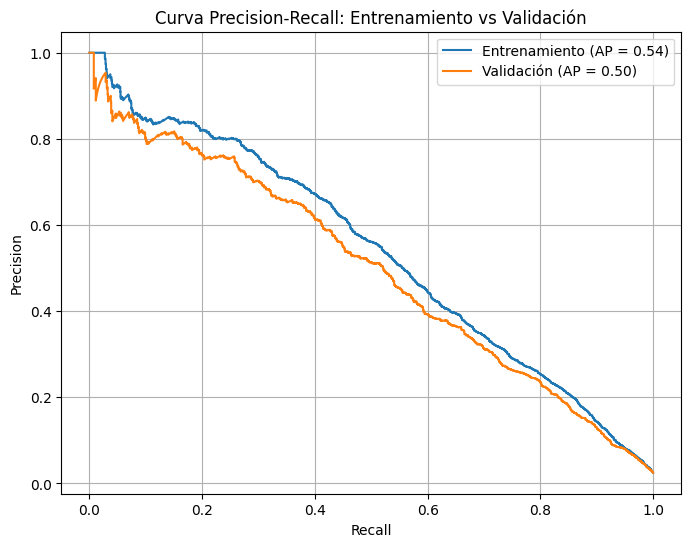

In [181]:
curva_precision_recall(df_train,pd.concat([df_test,df_dev]),model,variables=var_primarias,vd="vd",model_sm=False)

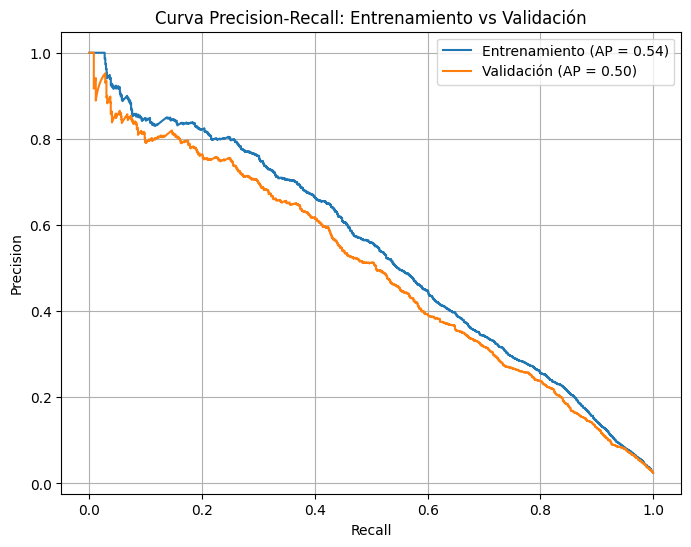

In [190]:
curva_precision_recall(df_train,pd.concat([df_test,df_dev]),modelo,variables=var_modelo,vd="vd",model_sm=True)

In [196]:
df_train['score'] = (model.predict_proba(df_train[var_primarias])[:,0]*1000).round().astype(int)
df_dev['score'] = (model.predict_proba(df_dev[var_primarias])[:,0]*1000).round().astype(int)
df_test['score'] = (model.predict_proba(df_test[var_primarias])[:,0]*1000).round().astype(int)
df_vo['score'] = (model.predict_proba(df_vo[var_primarias])[:,0]*1000).round().astype(int)

### 5.1 desciciones 

In [194]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

Profundidad del árbol: 3
Número de nodos terminales: 6


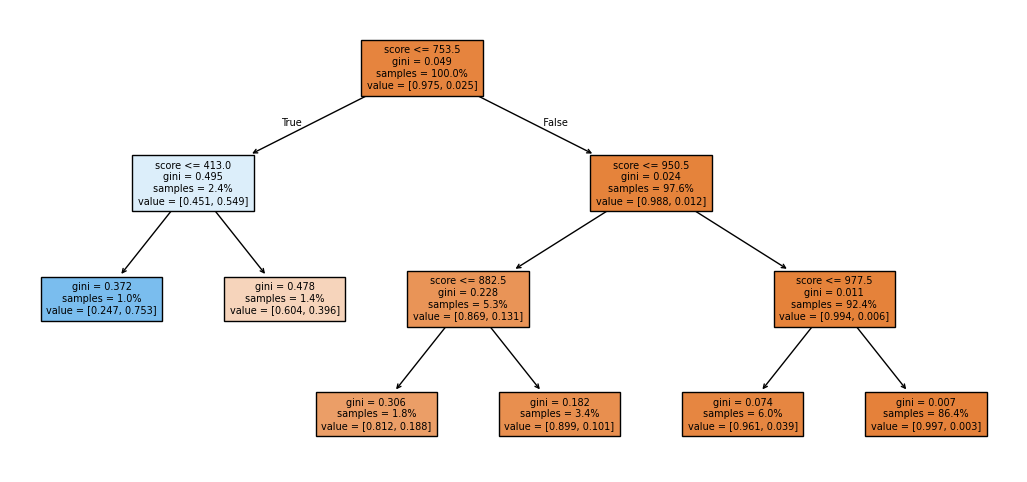

In [212]:
var='score'

X_train=df_train[df_train['vd'].isin([0,1])][[var]]
y_train=df_train[df_train['vd'].isin([0,1])]['vd']

modelo = DecisionTreeClassifier(
            max_depth         = 3,
            criterion         = 'gini',
            random_state      = 123,
            min_samples_split =0.01,
            min_samples_leaf =0.01
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

# Estructura del árbol creado
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = [var],
            #class_names   = var,
            filled        = True,
            impurity      = True,
            fontsize      = 7,
            proportion    = True,
            ax            = ax
       )

In [213]:
def decisiones(df,score='score'):
    df['decisiones']=np.where(df[score]>950,'1 - AAA',
                     np.where(df[score]>882,'2 - AA', 
                    np.where(df[score]>753,'3 - A',  
                    np.where(df[score]>430,'4 - Analiza','5 - Rechaza'))))
    
    return df['decisiones']


df_train['decisiones'] = decisiones(df_train,score='score')
df_dev['decisiones'] = decisiones(df_dev,score='score')
df_test['decisiones'] = decisiones(df_test,score='score')
df_vo['decisiones'] = decisiones(df_vo,score='score')

In [214]:
tabla_performance(df_train,vd,'score','decisiones')

ks 78.08 auc 95.14 gini 90.28


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,951,1000,94304,0.921928,0.921928,525,0.191536,0.005567,0.005567
2 - AA,883,950,3518,0.034392,0.956320,356,0.129880,0.101194,0.009006
3 - A,754,882,1870,0.018281,0.974602,352,0.128420,0.188235,0.012368
4 - Analiza,431,753,1352,0.013217,0.987819,539,0.196644,0.398669,0.017537
5 - Rechaza,3,430,1246,0.012181,1.000000,969,0.353521,0.777689,0.026796


In [216]:
tabla_performance(pd.concat([df_dev,df_test]),vd,'score','decisiones')

ks 76.32 auc 94.67 gini 89.34


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,951,1000,52938,0.921302,0.921302,318,0.206897,0.006007,0.006007
2 - AA,883,950,1988,0.034598,0.955900,202,0.131425,0.101610,0.009467
3 - A,754,882,1040,0.018100,0.973999,198,0.128822,0.190385,0.012829
4 - Analiza,431,753,780,0.013575,0.987574,286,0.186077,0.366667,0.017693
5 - Rechaza,2,430,714,0.012426,1.000000,533,0.346779,0.746499,0.026749


In [215]:
tabla_performance(df_vo,vd,'score','decisiones')

ks 93.82 auc 99.33 gini 98.66


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
decisiones,,,,,,,,,
1 - AAA,951,1000,11821,0.878232,0.878232,6,0.010526,0.000508,0.000508
2 - AA,883,950,565,0.041976,0.920208,8,0.014035,0.014159,0.001130
3 - A,754,882,260,0.019316,0.939525,19,0.033333,0.073077,0.002610
4 - Analiza,434,753,206,0.015305,0.954829,50,0.087719,0.242718,0.006458
5 - Rechaza,2,430,608,0.045171,1.000000,487,0.854386,0.800987,0.042348


In [105]:
tabla_performance(df_test,vd,score,desciones)

gini 81.8 auc 96.28 gini 92.56


,score_min,score_max,total,total%,totalCum%,malos,malo%,bad_rate,bad_rateCum
payerSalesSegment,,,,,,,,,
1,5.911181,968.044571,261,0.010270,0.010270,23,0.033626,0.088123,0.088123
2,5.509911,911.283654,328,0.012906,0.023175,55,0.080409,0.167683,0.132428
3,1.382328,998.376475,1276,0.050207,0.073382,136,0.198830,0.106583,0.114745
4,0.680847,997.744634,1137,0.044737,0.118119,154,0.225146,0.135444,0.122585
5,0.001382,990.062357,15639,0.615345,0.733464,311,0.454678,0.019886,0.036425
6,0.006012,338.123576,6774,0.266536,1.000000,5,0.007310,0.000738,0.026913


### 5.2 Importancia Variables 

In [ ]:
import shap


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [219]:
df_tranf=model.named_steps['preprocessor'].transform(df_train[var_primarias])

In [246]:
modelo_clf=model.named_steps['classifier']

var_modelo=['paymentDays_cap',
'amountFinanced_log_abs_cap',
'payerSalesSegment',
'expirationDays_log_abs_cap',
'prbm_sector']

clf_exp=shap.Explainer(
    modelo_clf,
    df_tranf,
    feature_names=var_modelo
    
)

shap_exp_values_clf=clf_exp(df_tranf)

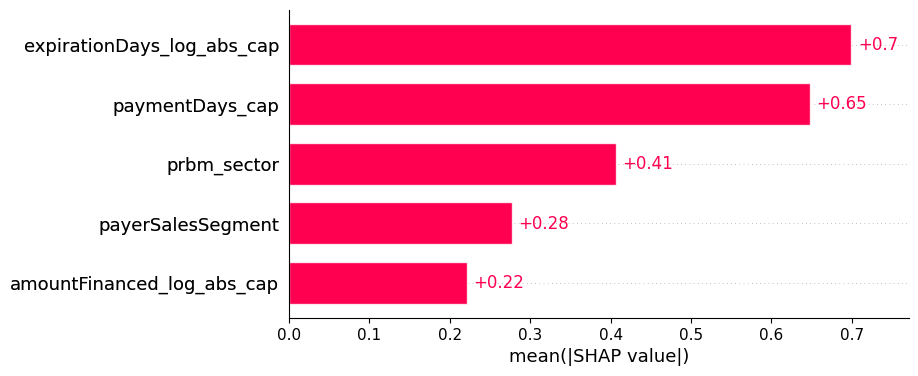

In [247]:
shap.plots.bar(shap_exp_values_clf)

In [ ]:
## La variable mas importante es expirationDays y paymentDays(dias de atrasos)


### 5.3 Simulaciones

In [244]:
var_plot=['paymentDays_cap',
'amountFinanced_log_abs_cap',
'payerSalesSegment',
'expirationDays_log_abs_cap',
'prbm_sector']

In [245]:
X_preprocessor=pd.DataFrame(model.named_steps['preprocessor'].transform(df_train[var_primarias].sample(n=500)),columns=var_plot)
modelo_classifier=model.named_steps['classifier']
X_preprocessor.head()

,paymentDays_cap,amountFinanced_log_abs_cap,payerSalesSegment,expirationDays_log_abs_cap,prbm_sector
0,10.0,17.864300,5.0,3.526361,0.002683
1,49.0,13.855779,5.0,4.317488,0.005458
2,-2.0,16.225287,6.0,3.433987,0.002683
3,-7.0,16.738656,5.0,4.143135,0.005458
4,-24.0,17.172480,5.0,4.369448,0.259167


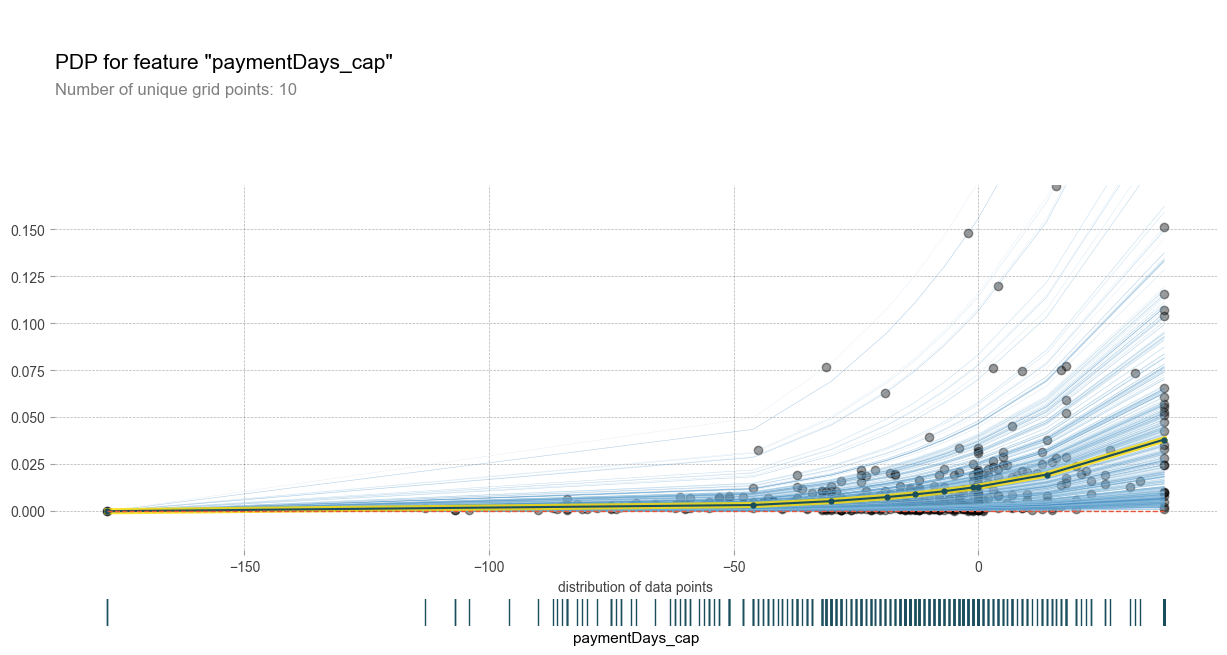

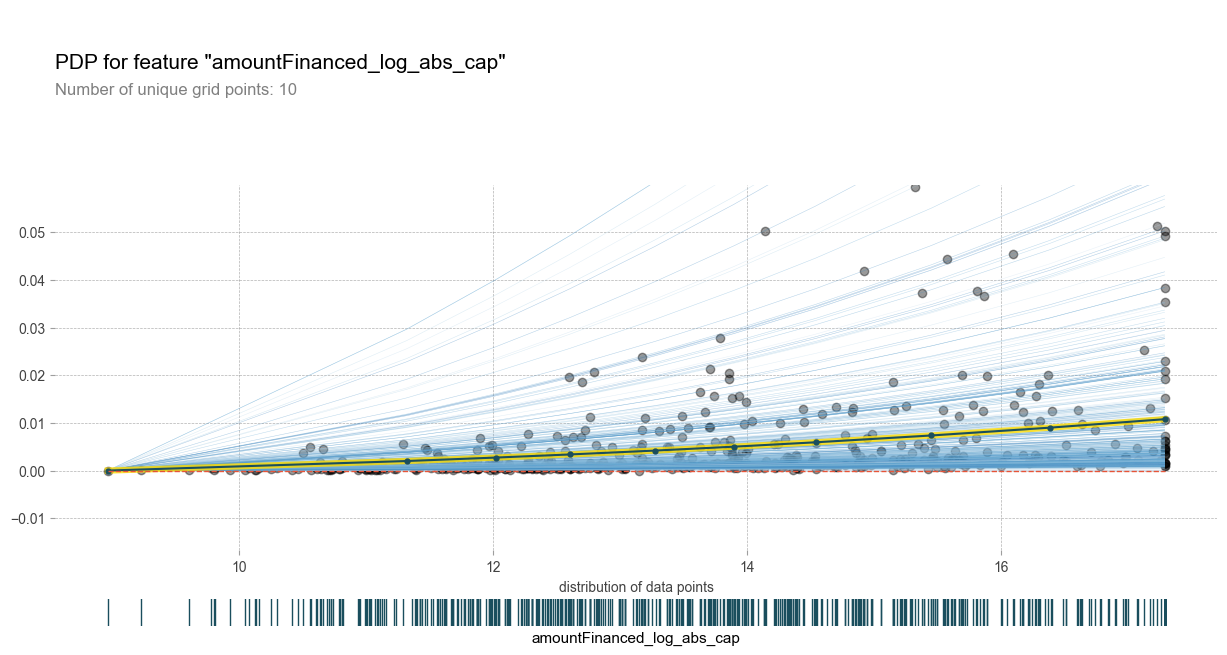

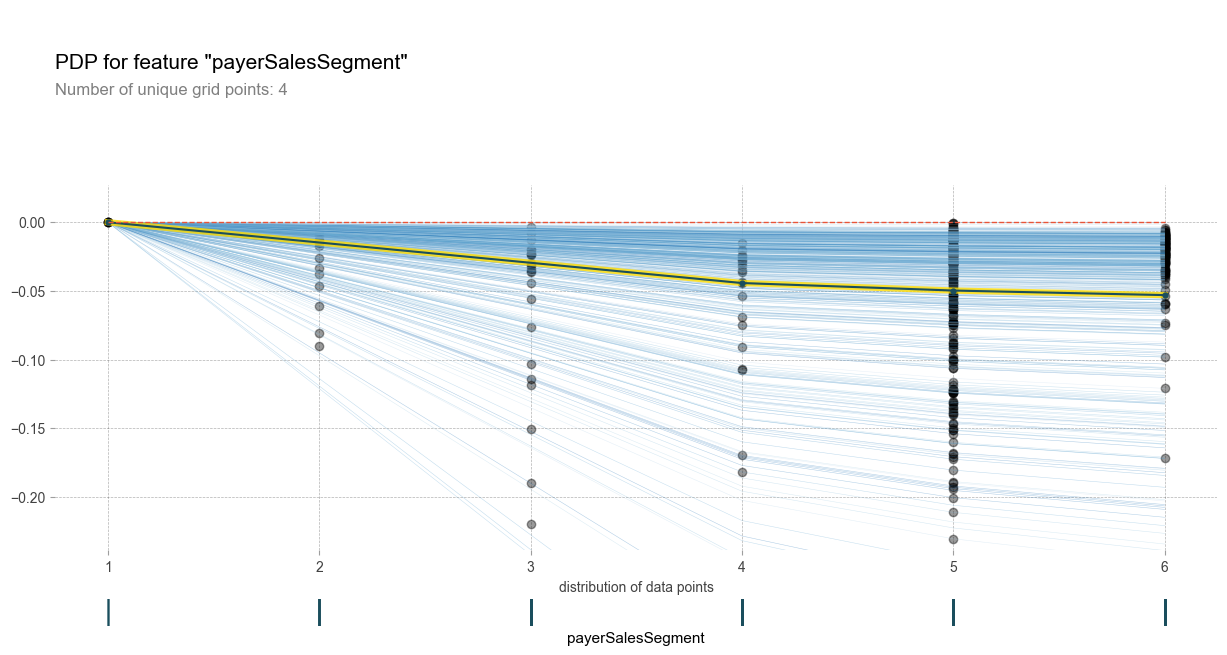

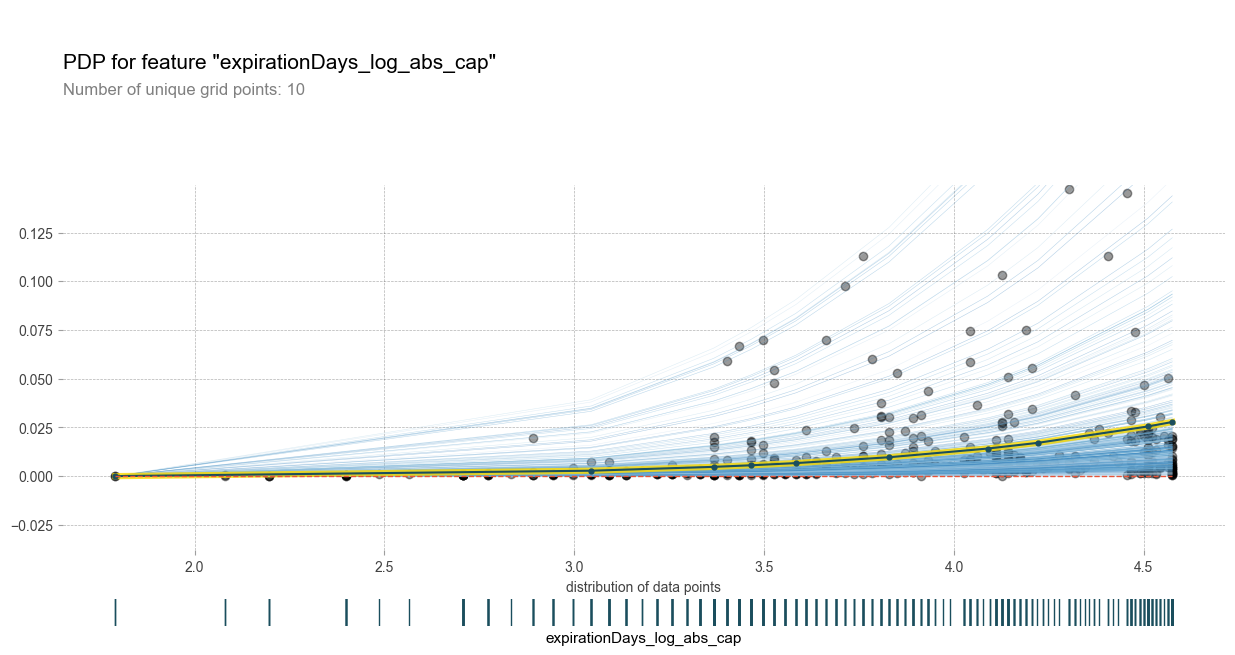

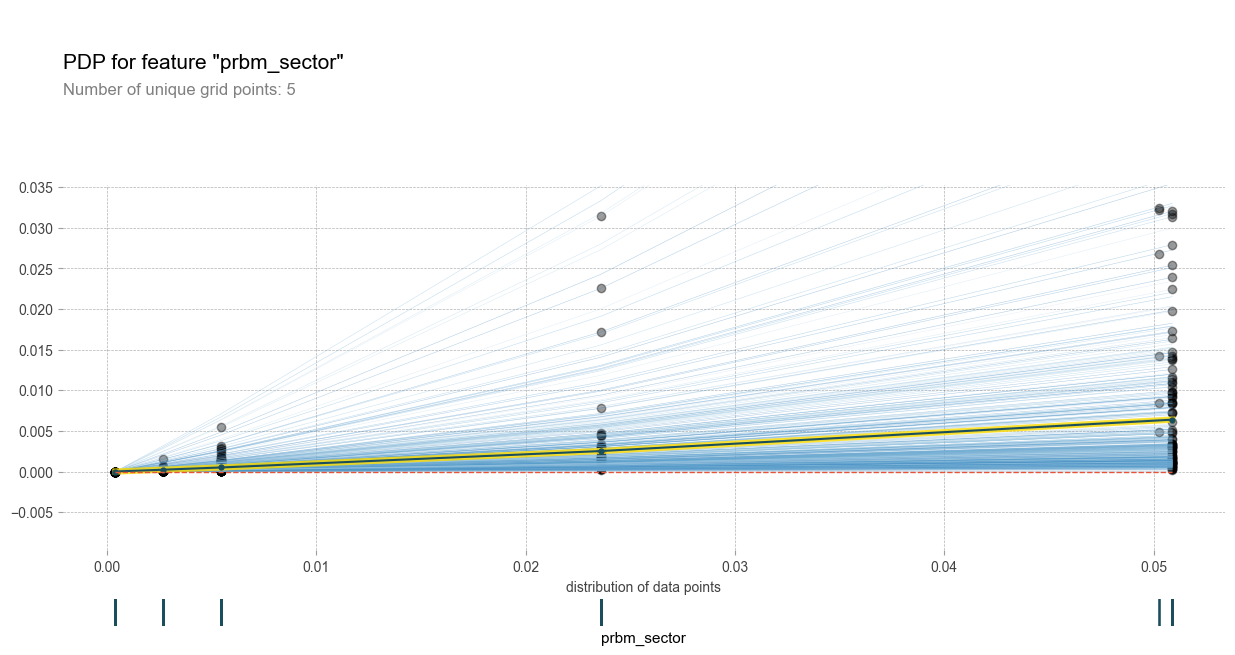

In [249]:
from pdpbox import pdp
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Desactivar las advertencias sobre la fuente 'Arial'
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


var_plot=['paymentDays_cap',
'amountFinanced_log_abs_cap',
'payerSalesSegment',
'expirationDays_log_abs_cap',
'prbm_sector']

varsstep=var_plot

# Iterar sobre las variables a analizar
for var_analisis in var_plot:


    # Cálculo de las curvas ICE (Individual Conditional Expectation)
    ice_df = pdp.pdp_isolate(
        model=modelo_classifier,
        dataset=X_preprocessor,
        feature=var_analisis,
        model_features=varsstep,
        grid_type="percentile",  # Tipo de discretización de los puntos
    )

    # Generación del gráfico PDP
    fig, axes = pdp.pdp_plot(
        ice_df,
        feature_name=var_analisis,
        center=True,
        plot_pts_dist=True,
        plot_lines=True,
        frac_to_plot=1,
        x_quantile=False,
        show_percentile=False,
        figsize=(15, 8),
        ncols=2,
        which_classes=None,
        #plot_params=plot_params,
    )

    # Agregar scatter de puntos reales versus diferencias de predicción
    axes["pdp_ax"]["_pdp_ax"].scatter(
        X_preprocessor[var_analisis],
        modelo_classifier.predict_proba(X_preprocessor)[:, 1] -
        ice_df.ice_lines.transpose().iloc[0, :],
        color="k",
        alpha=0.4,
    )

    # Mostrar los gráficos
    plt.show()


In [ ]:
## Se observa en los graficos que las variables tienen el signo correcto expirationDays_log_abs_cap a medida que aumenta se observa que tiene mayor probabilidad de caer en default ,
#  por el contrario payerSalesSegment cuando toma valores mas grande indica mayor solvensia y por ende menor probabilidad de default

## 6. Conclusiones modelo base

#### Ventajas de los Modelos Multiseries

- **Facilidad de Mantenimiento:** Es más fácil mantener y controlar un único modelo en lugar de gestionar varios modelos separados.

- **Mejor Aprendizaje con Series Cortas:** Al combinar todas las series temporales en un solo entrenamiento, el modelo puede aprender mejor incluso cuando algunas series tienen pocos datos. Esto se debe a que el modelo tiene acceso a un mayor número de observaciones.

- **Patrones Más Generalizables:** Al entrenar con múltiples series temporales juntas, el modelo puede captar patrones más generales que se aplican a diferentes series.

### Desventajas de los Modelos Multiseries

- **Dinámicas Internas Diferentes:** Si las series temporales no comparten la misma dinámica interna, el modelo puede aprender un patrón que no represente bien a ninguna de ellas.

- **Enmascaramiento de Series:** Algunas series pueden ocultar a otras, lo que podría resultar en un rendimiento desigual en las predicciones para diferentes series.

- **Mayor Costo Computacional:** Entrenar y realizar backtesting en un modelo multiseries grande requiere más tiempo y recursos computacionales en comparación con entrenar varios modelos más pequeños.

### Evaluación del Modelo y Sugerencias

- **Análisis del Error:** Se puede analizar la distribución del error, observando cómo varía en función de la fecha, el producto y la ciudad.

- **Agregar Más Variables:** Considera la posibilidad de incluir variables adicionales que puedan mejorar el modelo.

- **Optimización de Hiperparámetros:** Explora otros hiperparámetros para mejorar el rendimiento del modelo.

- **Cambiar el Tipo de Modelo:** Si es necesario, prueba con diferentes tipos de modelos para ver si se obtienen mejores resultados.

### Reflexión sobre la Calidad del Modelo

Para evaluar la calidad de un modelo, es importante compararlo con lo que se tenía antes. Si ya existía un modelo anterior, mide su desempeño contra el nuevo modelo. Si no había ningún modelo previo, un buen indicador es si el nuevo modelo proporciona predicciones dentro de los parámetros esperados según la experiencia, teniendo en cuenta el tiempo disponible para desarrollarlo.





In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
def curva_roc(dev,val,modelo,variables=var_modelo,vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:
        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]

    # Calcular la curva ROC
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_scores)
    roc_auc_train = roc_auc_score(y_train, y_train_scores)

    # Curva ROC para validación
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_scores)
    roc_auc_valid = roc_auc_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f"Entrenamiento (AUC = {roc_auc_train:.2f})")
    plt.plot(fpr_valid, tpr_valid, label=f"Validación (AUC = {roc_auc_valid:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Adivinanza Aleatoria")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
def curva_precision_recall(dev,val,modelo,variables=var_modelo,vd="vd",model_sm=True):
    
    y_train=dev[dev[vd].isin([0,1])][vd]
    y_valid=val[val[vd].isin([0,1])][vd]

    if model_sm:

        X_dev=sm.add_constant(dev[dev[vd].isin([0,1])][variables], prepend=True)
        X_val=sm.add_constant(val[val[vd].isin([0,1])][variables], prepend=True)

        y_train_scores=modelo.predict(exog = X_dev)
        y_valid_scores=modelo.predict(exog = X_val)
    else:

        y_train_scores=modelo.predict_proba(dev[dev[vd].isin([0,1])][variables])[:,1]
        y_valid_scores=modelo.predict_proba(val[val[vd].isin([0,1])][variables])[:,1]


    # Calcular la curva ROC
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_scores)
    ap_train = average_precision_score(y_train, y_train_scores)

    # Curva Precision-Recall para validación
    precision_valid, recall_valid, _ = precision_recall_curve(y_valid, y_valid_scores)
    ap_valid = average_precision_score(y_valid, y_valid_scores)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label=f"Entrenamiento (AP = {ap_train:.2f})")
    plt.plot(recall_valid, precision_valid, label=f"Validación (AP = {ap_valid:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall: Entrenamiento vs Validación")
    plt.legend()
    plt.grid()
    plt.show()    

vd='vd'
score="score"
desciones='payerSalesSegment'

from sklearn.metrics import roc_curve, roc_auc_score

def tabla_performance(df,vd,score,desciones):

    df=df[df[vd].isin([0,1,2])].copy()
    df['vd']=np.where(df[vd]==2,1,df[vd])

    df = df.sort_values(by=score, ascending=True)

    df['cum_bad'] = df[vd].cumsum() / df[vd].sum()
    df['cum_good'] = (1 - df[vd]).cumsum() / (1 - df[vd]).sum()
    df['ks'] = df['cum_bad'] - df['cum_good']


    ks_value = round(df['ks'].max()*100,2)
    auc = round(roc_auc_score(df[vd], 1000-df[score])*100,2)
    gini = round((2 * auc/100 - 1)*100,2)

    print(f"ks {ks_value}",f"auc {auc}",f"gini {gini}")


    df_tmp=df.groupby([desciones]).agg(
        score_min=(score,'min'),
        score_max=(score,'max'),
        malos=(vd,'sum'),
        total=(vd,'size'),
    )
    df_tmp["bad_rate"]=df_tmp["malos"]/df_tmp["total"]
    df_tmp["malo%"]=df_tmp["malos"]/df_tmp["malos"].sum()
    df_tmp["maloCum"]=df_tmp['malos'].cumsum()

    df_tmp["total%"]=df_tmp["total"]/df_tmp["total"].sum()
    df_tmp["totalCum"]=df_tmp['total'].cumsum()
    df_tmp["totalCum%"]=df_tmp['total%'].cumsum()
    df_tmp["bad_rateCum"]=df_tmp["maloCum"]/df_tmp["totalCum"]

    return df_tmp[["score_min","score_max",'total','total%',"totalCum%",'malos',"malo%",'bad_rate','bad_rateCum']]